In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import utils
from sklearn.model_selection import train_test_split
from keras.models import Model

Using TensorFlow backend.


In [2]:
fileloc = '/scratch/sk7898/pedbike'
filestrs = ['Human/human_radial_cuts_stft', 'Bike/bike_radial_cuts_stft']
window = 256
split = 0.1
filenames = []
data = []
labels = []
seqs = []

[[filenames.append(os.path.join(os.path.join(fileloc, filestr), filename))
  for filename in os.listdir(os.path.join(fileloc, filestr))] for filestr in filestrs]

[[data.append(np.fromfile(open(os.path.join(os.path.join(fileloc, filestr), filename), "r"), dtype=np.float64).reshape(-1, window*2))
  for filename in os.listdir(os.path.join(fileloc, filestr))] for filestr in filestrs]
data = np.array(data)

[labels.append(int((fname.split('_')[-1]).split('p')[0])) for fname in filenames]
labels = np.array(labels)

[seqs.append(int(fname.split('_')[-3])) for fname in filenames]
seqs = np.array(seqs)

indices = np.arange(len(filenames))
indices_train, indices_val = train_test_split(indices, test_size=split)

x_train = np.array([data[i] for i in indices_train])
x_val = np.array([data[i] for i in indices_val])

y_train = np.array([labels[i] for i in indices_train])
y_val = np.array([labels[i] for i in indices_val])

seqs_train = np.array([seqs[i] for i in indices_train])
seqs_val = np.array([seqs[i] for i in indices_val])

In [47]:
def histedges_equalN(seq_lengths, n_bins):
    npt = len(seq_lengths)
    return np.interp(np.linspace(0, npt, n_bins + 1),
                     np.arange(npt),
                     np.sort(seq_lengths))

def element_to_bucket_id(x, buckets_min, buckets_max):
    seq_length = x.shape[0]
    conditions_c = np.logical_and(np.less_equal(buckets_min, seq_length),
                                  np.less(seq_length, buckets_max))
    bucket_id = np.min(np.where(conditions_c))
    return bucket_id

def pad_sequence(x, max_len=None, padding_value=0):
    orig_length = x.shape[0]
    new_x = np.zeros((max_len, 512), dtype=np.float64)
    new_x[0:orig_length,:] = x
    return new_x
    
class BucketedBatch(keras.utils.Sequence):            
    def _permute(self):
        #Shuffle the buckets
        self.b_ids = np.random.permutation(self.n_bins)
        
        # Shuffle bucket contents
        for key in self.b_ids:
            xbin = np.array(self.buckets[key]['x'])
            ybin = np.array(self.buckets[key]['y'])
            #print(xbin.shape)
            index_array = np.random.permutation(len(self.buckets[key]['x']))
            self.buckets[key]['x'] = xbin[index_array]
            self.buckets[key]['y'] = ybin[index_array]

    def on_epoch_end(self):
        self._permute()
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return self.n_bins
    
    def __init__(self, n_bins, data, labels, seq_lengths, padding=None, padding_value=None):
        bucket_sizes, bucket_boundaries = np.histogram(seq_lengths, bins = histedges_equalN(seq_lengths, n_bins))
        #print(bucket_sizes)
        #print(bucket_boundaries)

        data_buckets = dict()
        boundaries = list(bucket_boundaries)
        buckets_min = boundaries[:-1]
        buckets_max = boundaries[1:]
        buckets_max[n_bins-1] += 1
        #print(buckets_min)
        #print(buckets_max)
        
        for x, y in zip(data, labels):
            b_id = element_to_bucket_id(x, buckets_min, buckets_max)
            if padding:
                if x.shape[0] < buckets_max[b_id]:
                    max_len = buckets_max[b_id] - 1
                    x = pad_sequence(x, max_len=int(max_len), padding_value=padding_value)
                    
            if b_id in data_buckets.keys():
                data_buckets[b_id]['x'].append(x)
                data_buckets[b_id]['y'].append(y)
            else:
                data_buckets[b_id] = {} 
                data_buckets[b_id]['x'] = [x]
                data_buckets[b_id]['y'] = [y]    
    
        self.n_bins = n_bins
        self.buckets = data_buckets
        self._permute()
        
    def __getitem__(self, idx):
        key = self.b_ids[idx]
        return self.buckets[key]['x'], self.buckets[key]['y']

In [58]:
def ValGenerator(x_val, y_val):
    idx = 0
    while True:
        for x, y in zip(x_val, y_val):
            idx += 1 
            x = x.reshape(1, x.shape[0], x.shape[1])
            label = np.zeros((1,1), dtype=np.int16)
            label[0] = y
            if idx >= y_val.shape[0]:
                break
            return x, label

In [59]:
batch_size = 64
n_bins = int(len(indices_train)/batch_size)

train_gen = BucketedBatch(n_bins, x_train, y_train, seq_lengths=seqs_train, padding=True, padding_value=0.0)
val_gen = ValGenerator(x_val, y_val)

In [ ]:
debug = False

if debug:
    def pad_sequence(x, max_len=None, padding_value=0):
        orig_length = x.shape[0]
        new_x = np.zeros((max_len, 512), dtype=np.float64)
        new_x[0:orig_length,:] = x
        return new_x
    
    def element_to_bucket_id(x, bucket_boundaries):
        seq_length = x.shape[0]
        boundaries = list(bucket_boundaries)
        buckets_min = [0] + boundaries
        buckets_max = boundaries + [np.iinfo(np.int32).max]
        conditions_c = np.logical_and(np.less_equal(buckets_min, seq_length),
                                      np.less(seq_length, buckets_max))
        bucket_id = np.min(np.where(conditions_c))
        return bucket_id
    
    def histedges_equalN(x, nbin):
        npt = len(x)
        return np.interp(np.linspace(0, npt, nbin + 1),
                         np.arange(npt),
                         np.sort(x))
    
    # Check the data shape
    d = np.fromfile(open(os.path.join(os.path.join(fileloc, 'Human/human_radial_cuts_stft'), 'human_fft_8_win_63_label_3p.data'), "r"), dtype=np.float64)
    d = d.reshape(-1, 512)
    assert d.shape == (63, 512)
    
    #check the bucket boundaries from the histogram 
    batch_size = 64
    nbin = int(len(filenames)/batch_size)
    bin_sizes, bin_edges, patches = plt.hist(seqs, histedges_equalN(seqs, nbin))
    print(bin_sizes)
    print(bin_edges)
    assert len(bin_sizes) == nbin
 
    #Test the data to bucket id functionality
    seq_length = 33
    boundaries = list(bin_edges[1:])
    buckets_min = [0] + boundaries
    buckets_max = boundaries + [np.iinfo(np.int32).max]
    conditions_c = np.logical_and(np.less_equal(buckets_min, seq_length),
                                  np.less(seq_length, buckets_max))
    bucket_id = np.min(np.where(conditions_c))
    print(buckets_min)
    print(buckets_max)
    assert bucket_id == 5
    
    #check the batch bucket generation
    data_buckets = dict()
    bucket_id = 5

    for x, y in zip(data, labels):
        b_id = element_to_bucket_id(x, boundaries)
        if b_id in data_buckets.keys():
            data_buckets[b_id]['x'].append(x)
            data_buckets[b_id]['y'].append(y)
        else:
            data_buckets[b_id] = {}
            data_buckets[b_id]['x'] = [x]
            data_buckets[b_id]['y'] = [y]
    
    print(data_buckets.keys())
    assert len(data_buckets.keys()) == nbin+1
    assert len(data_buckets[bucket_id]['x']) == bin_sizes[bucket_id]
    
    #Check the sequence padding functionality 
    x = np.array(data_buckets[bucket_id]['x'][0])
    bucket_boundary = boundaries[bucket_id]-1
    padded_seq = pad_sequence(x, max_len=int(bucket_boundary), padding_value=0.0)
    assert padded_seq.shape == (bucket_boundary, 512)
    
    #Test the Generator
    from keras.layers import Input, LSTM, Dense
    inp = Input(shape=(None, 512), dtype="float32", name="in")
    lstm = LSTM(128, return_sequences=False, name="lstm")(inp)
    dense = Dense(64, kernel_initializer='normal', activation='relu')(lstm)
    outputs = Dense(1, kernel_initializer='normal')(dense)
    model = Model(inputs=inp, outputs=outputs)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=['mae'])
    history = model.fit_generator(train_gen, validation_data=val_gen, validation_steps=1, steps_per_epoch = n_bins, epochs=1)

Epoch 1/10
13/13 [==============================] - 3s 210ms/step - loss: 6.4826 - mean_absolute_error: 2.2567 - val_loss: 3.0726 - val_mean_absolute_error: 1.7529
Epoch 2/10
13/13 [==============================] - 1s 58ms/step - loss: 5.2070 - mean_absolute_error: 1.9361 - val_loss: 1.7573 - val_mean_absolute_error: 1.3256
Epoch 3/10
13/13 [==============================] - 1s 53ms/step - loss: 3.3893 - mean_absolute_error: 1.4068 - val_loss: 0.1531 - val_mean_absolute_error: 0.3913
Epoch 4/10
13/13 [==============================] - 1s 54ms/step - loss: 1.7742 - mean_absolute_error: 1.0869 - val_loss: 0.1957 - val_mean_absolute_error: 0.4424
Epoch 5/10
13/13 [==============================] - 1s 53ms/step - loss: 1.5762 - mean_absolute_error: 1.1104 - val_loss: 0.1165 - val_mean_absolute_error: 0.3413
Epoch 6/10
13/13 [==============================] - 1s 55ms/step - loss: 1.4958 - mean_absolute_error: 1.0465 - val_loss: 0.0448 - val_mean_absolute_error: 0.2117
Epoch 7/10
13/13 [===

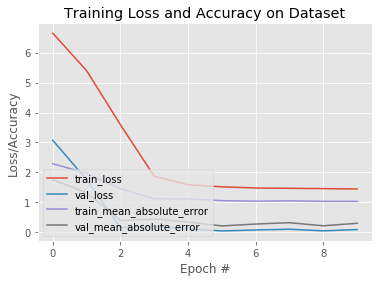

In [65]:
debug = True

if debug:
    epochs = 10
    #Test the Generator
    inp = Input(shape=(None, 512), dtype="float32", name="in")
    lstm = LSTM(32, return_sequences=False, name="lstm")(inp)
    dense = Dense(64, kernel_initializer='normal', activation='relu')(lstm)
    outputs = Dense(1, kernel_initializer='normal')(dense)
    model = Model(inputs=inp, outputs=outputs)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=['mae'])
    H = model.fit_generator(train_gen, validation_data=val_gen, validation_steps=1, steps_per_epoch=n_bins, epochs=epochs)
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["mean_absolute_error"], label="train_mean_absolute_error")
    plt.plot(np.arange(0, epochs), H.history["val_mean_absolute_error"], label="val_mean_absolute_error")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")